# This is the driver program for the ARIMA process. 

- It starts with testing stationarity.
- Then it runs a grid search for the best parameters. It returns the best parameters and we use those going forward.
- Then we summarize residual errors for the model.
- Then we summarize residual errors from bias corrected forecasts.
- Plots test vs prediction scores
- Saves finalized model to file
- Loads the finalized model and makes a prediction. This proves that it works.
- Then finally we forecast for the balance of the year.

## Update the John Hopkins, Covid-19 data 
https://github.com/CSSEGISandData/COVID-19 by refreshing your local copy of the GitHub repository. 

In [29]:
# import libraries
import numpy as np
import pandas as pd
import pickle
import stationarity as st
import load_data as ld
import arima_grid_search as ags
import summarize
import test_prediction_save_forecast_1day as tpsf1
import multi_step_forecast as msf

## Prepare arguments for driver

In [30]:
arg_dict = {'file_name_1': r'data\all_df.csv',
            'file_name_2': r'C:\Users\linds\OneDrive\mystuff\GitHub\covid\data\country_codes_edited.csv',
            'feature': 'Alpha_3',
            'place': 'USA',
            'dependent_variable': 'Deaths',
            'path': r'C:\Users\linds\OneDrive\mystuff\GitHub\COVID-19\csse_covid_19_data\csse_covid_19_daily_reports',
            'best_cfg': (1,1,0), # I initially tried p,d,q of 7,2,0 based on the ACF and PACF. It did not converge.
            'order_list': [],
            'p_values': range(0,5),
            'd_values': range(0,5),
            'q_values': range(0,5),
            'split_value': .5,
            'bias': 0, # First time thru bias is 0
            'date': '12-31-2020'}

## Load John Hopkins data

The "data date" is 2020-08-08 00:00:00

ADF Statistic: -2.248954
p-value: 0.188960
Critical Values:
	1%: -3.475
	5%: -2.881
	10%: -2.577


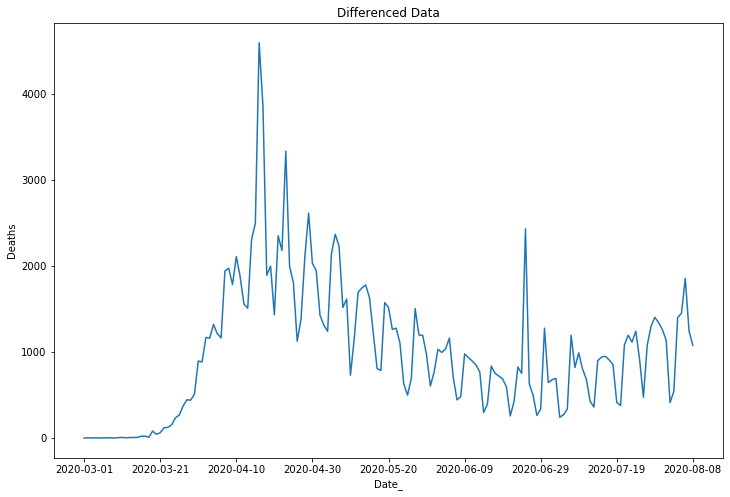

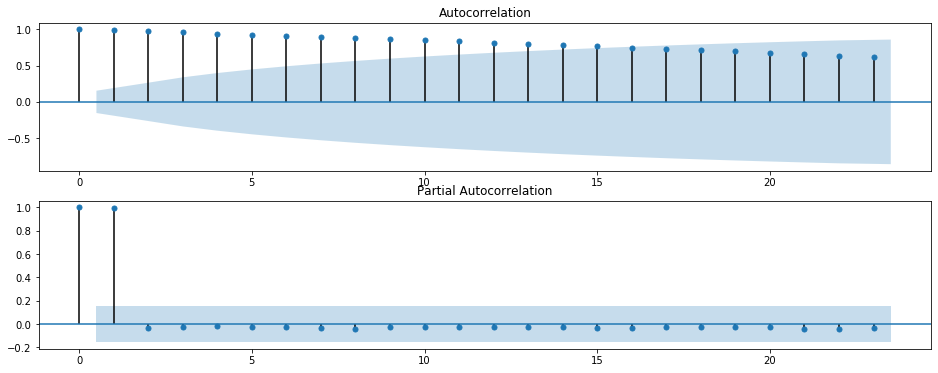

RMSE is 63959.976 with ARIMA of (0, 0, 1)
RMSE is 643.075 with ARIMA of (0, 1, 1)
RMSE is 576.877 with ARIMA of (0, 1, 2)
RMSE is 506.162 with ARIMA of (0, 1, 3)
RMSE is 506.387 with ARIMA of (0, 1, 4)
RMSE is 425.659 with ARIMA of (0, 2, 1)
RMSE is 384.934 with ARIMA of (0, 2, 2)
RMSE is 388.005 with ARIMA of (0, 2, 3)
RMSE is 408.211 with ARIMA of (0, 2, 4)
RMSE is 961.119 with ARIMA of (1, 0, 0)
RMSE is 420.396 with ARIMA of (1, 1, 0)
RMSE is 418.668 with ARIMA of (1, 1, 1)
RMSE is 384.204 with ARIMA of (1, 1, 2)
RMSE is 386.661 with ARIMA of (1, 1, 3)
RMSE is 410.798 with ARIMA of (1, 1, 4)
RMSE is 426.289 with ARIMA of (1, 2, 0)
RMSE is 369.861 with ARIMA of (1, 2, 4)
RMSE is 418.745 with ARIMA of (2, 1, 0)
RMSE is 386.741 with ARIMA of (2, 1, 2)
RMSE is 369.136 with ARIMA of (2, 1, 4)
RMSE is 424.935 with ARIMA of (2, 2, 0)
RMSE is 361.662 with ARIMA of (2, 2, 2)
RMSE is 324.936 with ARIMA of (2, 2, 3)
RMSE is 419.78 with ARIMA of (3, 0, 0)
RMSE is 418.703 with ARIMA of (3, 1, 0)

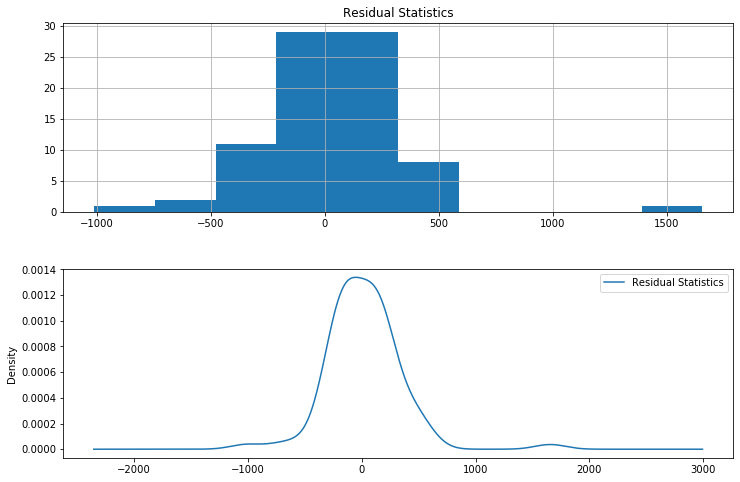


bias IS saved in arg_dict["bias"] for subsequent run is: 21.25682124041774 


RMSE: 323.373
       Residual Statistics
count         8.100000e+01
mean          2.874452e-12
std           3.253883e+02
min          -1.035672e+03
25%          -1.787580e+02
50%          -2.125482e+00
75%           1.530861e+02
max           1.634961e+03


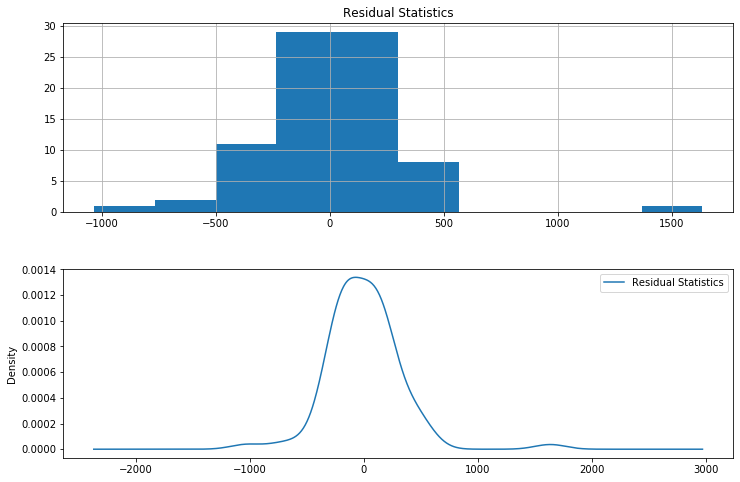


bias NOT saved in arg_dict["bias"] for subsequent run is: 2.8744523907885138e-12 



In [31]:
df, li_set = ld.driver(arg_dict)

# Get the date of the last row in the file to establish the currency of the data.
print(f'The "data date" is {df["Date_"].iloc[-1]}\n')

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Test for stationarity
df = st.driver(arg_dict)

# save df for subsequent independent processing
df.to_csv('df.csv')
      
# Grid search ARIMA parameters 
order_list = ags.driver(df, arg_dict)
arg_dict.update({'order_list': order_list})
arg_dict.update({'best_cfg': order_list[0]})

# summarize residual errors for an ARIMA model and return bias
model_fit, test, predictions = summarize.driver(df, arg_dict)

# Rerun summarize, as bias adjusted
model_fit, test, predictions = summarize.driver(df, arg_dict)
arg_dict.update({'test': test, 'predictions': predictions, 'model_fit': model_fit})

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


## Plot test (actual) vs predictions, save, and forecast

The predicted cumulative Deaths for USA for tomorrow (input data plus 1 day) are 162,293


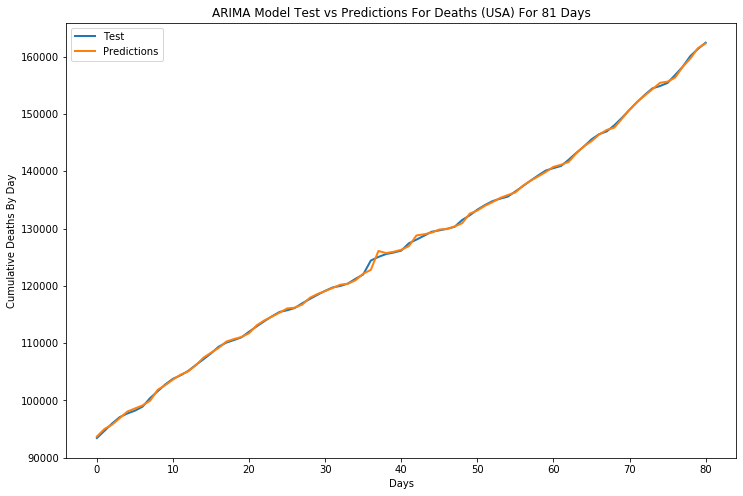

In [32]:
tpsf1.driver(arg_dict)

NB The above prediction of a single day in the future will only rarely match the the first day in the multi step forecast below. The reason is that the ARIMA model is a moving average model. The specific days included in the moving average change in the multi step forecast. 

## Multi step forecast

The USA prediction is for 305,051 cumulative Deaths to occur by 2020-12-31 00:00:00


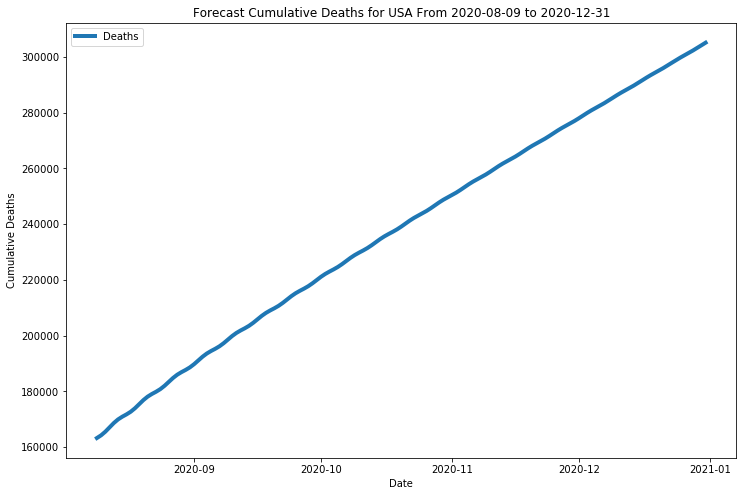

In [33]:
df.index = pd.to_datetime(df.index)
forecast_df = msf.driver(df, arg_dict)

If the arg_dict has a prediction date later than the above date, the reason is that ARIMA expects the jurisdiction to have no more instances by the date indicated. We truncate the prediction at that point. 

In [34]:
new_col = "Daily_" + arg_dict['dependent_variable']
df[new_col] = df[arg_dict['dependent_variable']] - df[arg_dict['dependent_variable']].shift()
print('Actual')
df.tail() 

Actual


,Deaths,Daily_Deaths
Date_,,
2020-08-04,156801.0,1399.0
2020-08-05,158250.0,1449.0
2020-08-06,160104.0,1854.0
2020-08-07,161347.0,1243.0
2020-08-08,162423.0,1076.0


In [35]:
forecast_df[new_col] = forecast_df[arg_dict['dependent_variable']] - forecast_df[arg_dict['dependent_variable']].shift()
forecast_df.iloc[0,1] = forecast_df.iloc[0,0] - df.iloc[-1,0]
print('Predicted')
forecast_df.head()

Predicted


,Deaths,Daily_Deaths
Date_,,
2020-08-09,163292.0,869.0
2020-08-10,164272.0,980.0
2020-08-11,165568.0,1296.0
2020-08-12,167119.0,1551.0
2020-08-13,168669.0,1550.0
